In [12]:
import pandas as pd
import numpy as np

import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [2]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])


In [3]:
def get_image_filenames(face_dir):
    return sorted(os.listdir(face_dir))  # assumes same names in face/ and comics/


In [4]:
def get_dataset(root_dir, image_size=256):
    face_dir = os.path.join(root_dir, 'face')
    comic_dir = os.path.join(root_dir, 'comics')
    filenames = get_image_filenames(face_dir)

    transform = T.Compose([
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize([0.5]*3, [0.5]*3)
    ])

    def dataset_fn(index):
        fname = filenames[index]
        face_path = os.path.join(face_dir, fname)
        comic_path = os.path.join(comic_dir, fname)

        face = Image.open(face_path).convert("RGB")
        comic = Image.open(comic_path).convert("RGB")

        face = transform(face)
        comic = transform(comic)

        return {
            'face': face,
            'comic': comic,
            'filename': fname
        }

    return dataset_fn, len(filenames)


In [5]:
def get_dataloader_from_fn(dataset_fn, dataset_len, batch_size=16, shuffle=True, num_workers=2):
    class FunctionalDataset(Dataset):
        def __len__(self): return dataset_len
        def __getitem__(self, idx): return dataset_fn(idx)

    return DataLoader(FunctionalDataset(), batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)


In [6]:
dataset_fn, dataset_len = get_dataset('archive/face2comics', image_size=256)
dataloader = get_dataloader_from_fn(dataset_fn, dataset_len, batch_size=8, shuffle=True, num_workers=0)

for batch in dataloader:
    print(batch['face'].shape, batch['comic'].shape)
    break


torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256])


In [7]:
def show_real_vs_comic(real, comic, max_images=8):
    real = real[:max_images]
    comic = comic[:max_images]

    # De-normalize from [-1, 1] back to [0, 1]
    real = (real * 0.5) + 0.5
    comic = (comic * 0.5) + 0.5

    fig, axes = plt.subplots(2, max_images, figsize=(3 * max_images, 6))

    for i in range(max_images):
        axes[0, i].imshow(real[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis('off')
        axes[0, i].set_title("Real")

        axes[1, i].imshow(comic[i].permute(1, 2, 0).cpu().numpy())
        axes[1, i].axis('off')
        axes[1, i].set_title("Comic")

    plt.tight_layout()
    plt.show()

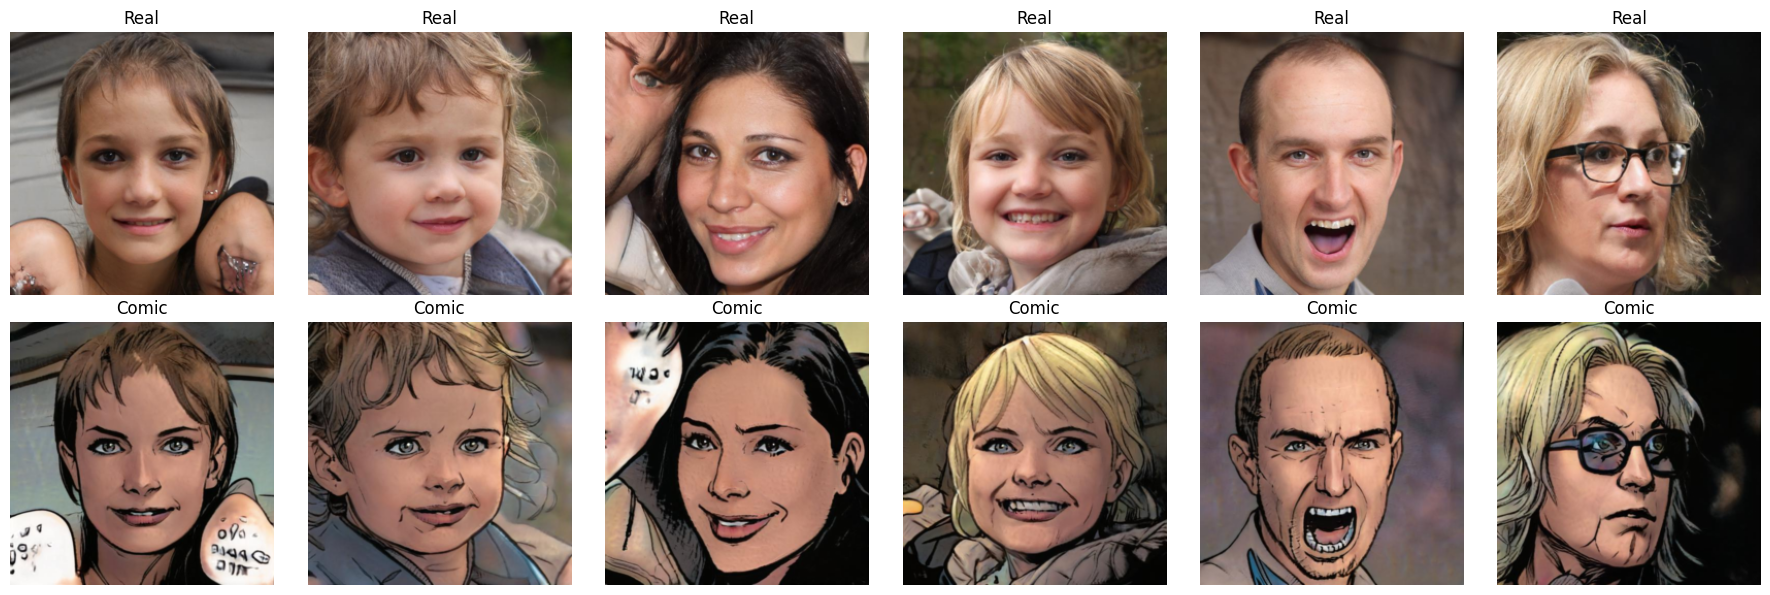

In [8]:
for batch in dataloader:
    show_real_vs_comic(batch['face'], batch['comic'], max_images=6)
    break


In [9]:
def plot_pixel_histogram(image_tensor, title="Histogram"):
    img = image_tensor[0]  # Take first image in batch
    img = (img * 0.5) + 0.5  # De-normalize to [0, 1]
    img = img.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(8, 4))
    for i, color in enumerate(['r', 'g', 'b']):
        plt.hist(img[..., i].ravel(), bins=256, color=color, alpha=0.5, label=color)
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Count")
    plt.legend()
    plt.show()


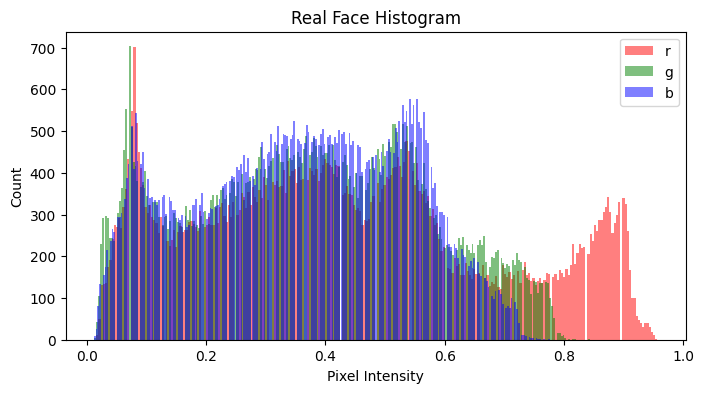

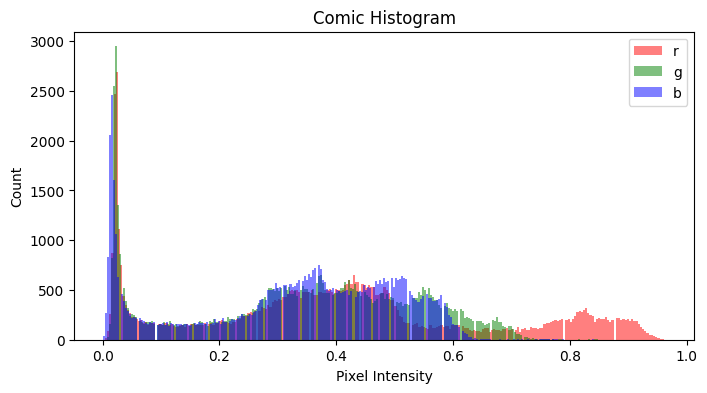

In [10]:
for batch in dataloader:
    plot_pixel_histogram(batch['face'], title="Real Face Histogram")
    plot_pixel_histogram(batch['comic'], title="Comic Histogram")
    break


U-Net Generator

In [ ]:
def down_block(in_channels, out_channels, normalize=True):
    layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
    if normalize:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

def up_block(in_channels, out_channels, dropout=0.0):
    layers = [
        nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if dropout:
        layers.append(nn.Dropout(dropout))
    return nn.Sequential(*layers)

def build_unet_generator():
    d1 = down_block(3, 64, normalize=False)
    d2 = down_block(64, 128)
    d3 = down_block(128, 256)
    d4 = down_block(256, 512)
    d5 = down_block(512, 512)
    
    u1 = up_block(512, 512)
    u2 = up_block(1024, 256)
    u3 = up_block(512, 128)
    u4 = up_block(256, 64)
    
    final = nn.Sequential(
        nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
        nn.Tanh()
    )
    
    def forward(x):
        d1_out = d1(x)
        d2_out = d2(d1_out)
        d3_out = d3(d2_out)
        d4_out = d4(d3_out)
        d5_out = d5(d4_out)

        u1_out = u1(d5_out)
        u1_out = torch.cat((u1_out, d4_out), 1)
        
        u2_out = u2(u1_out)
        u2_out = torch.cat((u2_out, d3_out), 1)
        
        u3_out = u3(u2_out)
        u3_out = torch.cat((u3_out, d2_out), 1)
        
        u4_out = u4(u3_out)
        u4_out = torch.cat((u4_out, d1_out), 1)
        
        output = final(u4_out)
        return output
    
    return forward


LightResNet Generator

In [ ]:
def residual_block(in_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(in_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(in_channels)
    )

def build_lightresnet_generator():
    encoder = nn.Sequential(
        nn.Conv2d(3, 64, 4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 128, 4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 256, 4, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
    )
    
    res_blocks = nn.Sequential(
        residual_block(256),
        residual_block(256),
        residual_block(256)
    )
    
    decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        
        nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
        nn.Tanh()
    )
    
    def forward(x):
        e = encoder(x)
        r = res_blocks(e)
        out = decoder(r)
        return out
    
    return forward


PatchGAN Discriminator

In [ ]:
def build_patchgan_discriminator():
    model = nn.Sequential(
        nn.Conv2d(6, 64, 4, stride=2, padding=1),   # Input: real+fake images stacked
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(64, 128, 4, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(128, 256, 4, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(256, 512, 4, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        
        nn.Conv2d(512, 1, 4, stride=1, padding=1),  # Output: Patch map (real/fake)
        nn.Sigmoid()
    )
    
    def forward(x_real, x_fake):
        x = torch.cat((x_real, x_fake), 1)  # Concatenate along channel dimension
        return model(x)
    
    return forward


LightResNet Loss Function

In [ ]:
# Loss functions for LightResNet (GAN loss only)

bce_loss = nn.BCEWithLogitsLoss()

def gan_loss(predicted, target_is_real):
    """Calculates standard GAN loss"""
    target = torch.ones_like(predicted) if target_is_real else torch.zeros_like(predicted)
    return bce_loss(predicted, target)


U-Net Generator Loss Function

In [ ]:
# Loss functions for U-Net (GAN + L1)

l1_loss = nn.L1Loss()

def unet_combined_loss(pred_fake, pred_real, fake_image, target_image, lambda_L1=100):
    """
    pred_fake: output from discriminator on fake images
    pred_real: output from discriminator on real images
    fake_image: generated image
    target_image: ground truth image
    """
    gan = gan_loss(pred_fake, True)  # Generator wants to fool the discriminator
    l1 = l1_loss(fake_image, target_image) * lambda_L1
    return gan + l1


In [ ]:
def train_model(generator_forward, discriminator_forward, dataloader, num_epochs=100, device='cuda', lambda_L1=100, use_l1=True):
    generator = generator_forward
    discriminator = discriminator_forward
    
    # Optimizers
    opt_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    opt_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    
    for epoch in range(num_epochs):
        for idx, (input_image, target_image) in enumerate(dataloader):
            input_image = input_image.to(device)
            target_image = target_image.to(device)

            # === Train Discriminator ===
            opt_D.zero_grad()

            # Real pair
            pred_real = discriminator(input_image, target_image)
            loss_real = gan_loss(pred_real, True)

            # Fake pair
            fake_image = generator(input_image)
            pred_fake = discriminator(input_image, fake_image.detach())  # Detach to avoid gradients to G
            loss_fake = gan_loss(pred_fake, False)

            # Total discriminator loss
            loss_D = (loss_real + loss_fake) * 0.5
            loss_D.backward()
            opt_D.step()

            # === Train Generator ===
            opt_G.zero_grad()

            # Generator tries to fool discriminator
            pred_fake_for_g = discriminator(input_image, fake_image)

            if use_l1:
                loss_G = unet_combined_loss(pred_fake_for_g, pred_real, fake_image, target_image, lambda_L1)
            else:
                loss_G = gan_loss(pred_fake_for_g, True)

            loss_G.backward()
            opt_G.step()

            if idx % 50 == 0:
                print(f"Epoch [{epoch}/{num_epochs}] Batch [{idx}/{len(dataloader)}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")


In [ ]:
train_model(unet_generator, patchgan_discriminator, dataloader, num_epochs=200, device='cuda', use_l1=True)


In [ ]:
train_model(lightresnet_generator, patchgan_discriminator, dataloader, num_epochs=200, device='cuda', use_l1=False)
